# Elastic Halfspace Dislocation Model of San Andreas (Parkfield Creeping Segment)

### Savage and Burford Model for vertical strike-slip faults: velocity at the free surface

$$
V(x) = \frac{v_o}{\pi}\arctan \big(\frac{x}{D}\big) + v_2
$$

where $V(x)$ is the velocity of points along a perpendicular transect of the fault, x = 0 is the intersection of the fault with the transect, $v_o$ is the far field velocity, $D$ is the locking depth of the fault. 

In [ ]:
from IPython.display import IFrame
IFrame("test02.pdf", width=500, height=700)

### Component of Velocity Along the Fault (Perpendicular to the Transect)

Assuming that the strike of San Andreas Fault is $65^o$ West of North, the velocity component along the (parallel to) fault will be: 
$$
V_{SAF}^{||} = V_N\cos\theta - V_E\sin\theta
$$

where $\theta = 65^o$, and $V_N$, $V_E$ are North and East components of velocity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
gps_vels = np.genfromtxt("projection.dat")

vN = gps_vels[:,3]
vE = gps_vels[:,2]
θ = np.deg2rad(65)
xlon = gps_vels[:,8]

x = (xlon - np.mean(xlon))*111

# angle of velocity vector w.r.t. east
α = np.arctan(vN/vE)

# angle between velocity vector Vo and SAF
ω = θ + np.deg2rad(90) - α

# Rotation Matrix 
#R = [[np.cos(ω), np.sin(ω)], [-np.sin(ω), np.cos(ω)]]

vSAF = np.zeros(len(xlon))

for i in range(len(xlon)):
    R = [[np.cos(ω[i]), np.sin(ω[i])], [-np.sin(ω[i]), np.cos(ω[i])]]
    vr = np.dot(R, [vN[i], vE[i]])
    
    vSAF[i] = np.linalg.norm(vr)

vSAF2 = np.abs(vN*np.cos(np.deg2rad(θ)) - vE*np.sin(np.deg2rad(θ)))

In [3]:
# Error Propagation
# Assume The correlation between N and E errors are very small
σN = gps_vels[:,5]
σE = gps_vels[:,4]

σSAF = np.abs(vSAF)*np.sqrt( (σN/vN)**2 + (σE/vE)**2 )

In [4]:
# Calculate the standard deviation of the rotated data vSAF.

# This should be equal to the eigenvectors of the covariance matrix of vN and vE assuming that all the
# motion in a strike-slip fault is always along the fault.

# Or manybe just the principal component analysis

#np.linalg.eig(np.cov(vE,vN))

In [5]:
#ind = np.argsort(x)

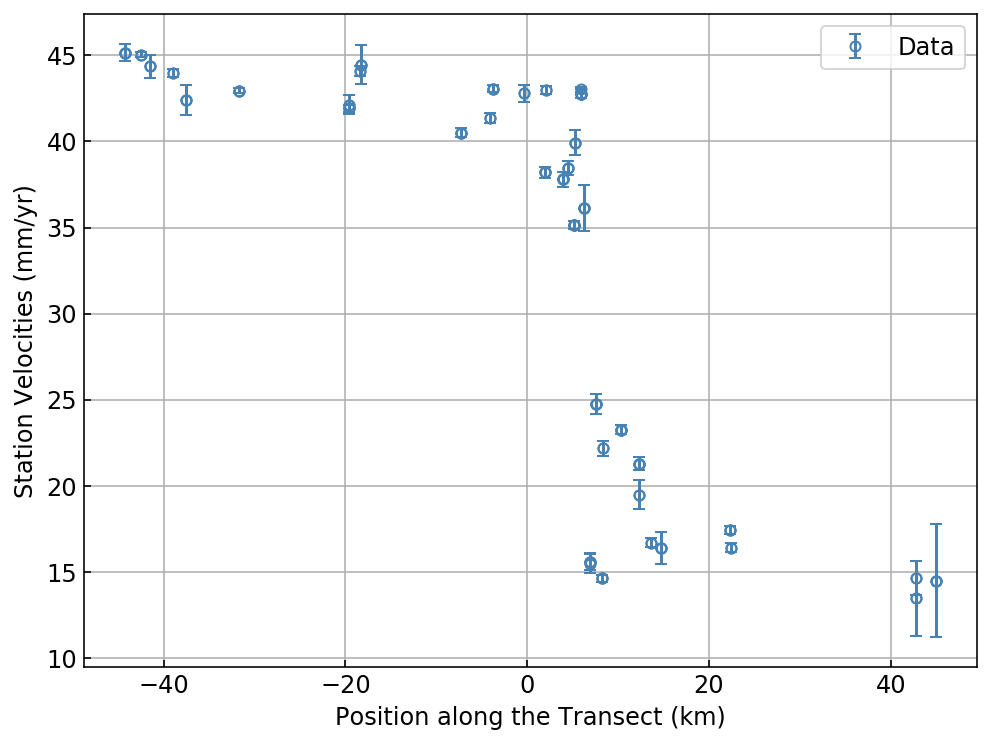

In [6]:
# Plot GPS along fault
fig = plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(111)
#ax.scatter(x, vSAF, s=20, marker="o")
ax.errorbar(x, vSAF, yerr=σSAF, ms=5, mec="steelblue", mfc="none", ecolor="steelblue", capsize=3, fmt="o", label="Data")
ax.set_xlabel("Position along the Transect (km)")
ax.set_ylabel("Station Velocities (mm/yr)")
ax.get_yaxis().set_tick_params(which='both', direction='in')
ax.get_xaxis().set_tick_params(which='both', direction='in')
plt.rc('grid', linestyle="--", color='black', alpha=0.5)
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# Forward model to calculate the station velocities given locking depth and far field loading
def forward_model(x, D, vo, xo, v2):
    return -(vo/np.pi)*np.arctan((x-xo)/D) + v2

In [28]:
# Forward model to accommodate for shallow creep
v2_ref = 29.4562; xo_ref = 6.587025
def forward_model2(x, D1, D2, vo):
    return -(vo/np.pi)*(np.arctan(D1/(x-xo_ref)) + np.arctan((x-xo_ref)/D2)) + v2_ref

### Model Fit: Bayesian Monte Carlo

Search Space: 0< D < 50 km, 0 < $v_o$ < 50 mm/yr

In [ ]:
#import scipy.optimize as optimize

In [ ]:
#popt, pcov = optimize.curve_fit(forward_model2, x, vSAF)

In [29]:
# Trial models
ntrials = 600000

# temp

# Initial Random Number based on the search space
D1_trial = np.random.uniform(0,15,ntrials)
D2_trial = np.random.uniform(0,15,ntrials)
vo_trial = np.random.uniform(20,40,ntrials)
xo_trial = np.random.uniform(0,10,ntrials)
#x1_trial = np.random.uniform(0,40,ntrials)
v2_trial = np.random.uniform(25,35,ntrials)

# Calculate misfit and residual
Vpred = np.zeros((len(x),ntrials))
l2_misfit = np.zeros((ntrials))

for i in range(ntrials):
    #Vpred[:,i] = forward_model(x, D1_trial[i],vo_trial[i], xo_trial[i], v2_trial[i])
    Vpred[:,i] = forward_model2(x, D1_trial[i], D2_trial[i], vo_trial[i])
    residual = np.abs((vSAF - Vpred[:,i])/σSAF)
    l2_misfit[i] = (np.linalg.norm(residual))
    
# L2 misfit
#l2_misfit = np.linalg.norm(residual, axis=0)

# Likelihood
L2_norm = (l2_misfit - np.amin(l2_misfit))

# Normalized Likelihood
L = np.exp(-0.5*L2_norm)
#L = np.abs(l2_misfit)/np.amax(l2_misfit)

# Posterior model index 
D1_post = np.zeros(ntrials)
D2_post = np.zeros(ntrials)
vo_post = np.zeros(ntrials)
xo_post = np.zeros(ntrials)
#x1_post = np.zeros(ntrials)
v2_post = np.zeros(ntrials)
misfit_post = np.zeros((ntrials))

# Accept posterior models
for j in range(ntrials):
    if L[j] > np.random.uniform():
        D1_post[j] = D1_trial[j]
        D2_post[j] = D2_trial[j]
        vo_post[j] = vo_trial[j]
        #xo_post[j] = xo_trial[j]
        #v2_post[j] = v2_trial[j]
        misfit_post[j] = L[j]
        
        
# Posterior model estimates 
D1_post = list(filter(lambda x: x!=0, D1_post))
D2_post = list(filter(lambda x: x!=0, D2_post))
vo_post = list(filter(lambda x: x!=0, vo_post))
#xo_post = list(filter(lambda x: x!=0, xo_post))
#v2_post = list(filter(lambda x: x!=0, v2_post))
misfit_post = list(filter(lambda x: x!=0, misfit_post))

In [32]:
# Posterior models
Vpost = np.zeros((len(x),len(vo_post)))

x2 = np.linspace(np.min(x), np.max(x), num=len(x))

for i in range(len(vo_post)):
    #Vpost[:,i] = forward_model(x2, D1_post[i],vo_post[i], xo_post[i], v2_post[i])
    Vpost[:,i] = forward_model2(x2, D1_post[i], D2_post[i], vo_post[i])

# Most likely models
D1_ml = np.mean(D1_post)
D2_ml = np.mean(D2_post)
vo_ml = np.mean(vo_post)
#xo_ml = np.mean(xo_post)
#v2_ml = np.mean(v2_post)
#Vmost_likely = forward_model(x2, D1_ml, vo_ml, xo_ml, v2_ml)
Vmost_likely = forward_model2(x2, D1_ml, D2_ml, vo_ml)

In [33]:
vo_ml

30.750400971351585

In [34]:
D1_ml, D2_ml

(1.3770929607111766, 6.084430885923744)

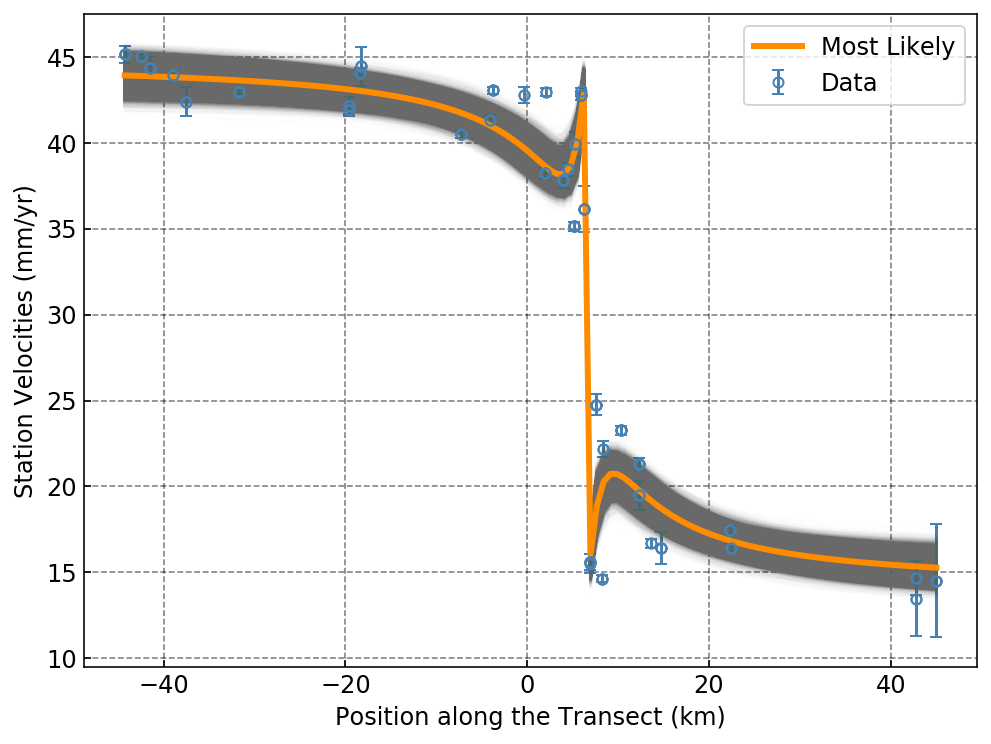

In [57]:
# Plot acccepted models
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 12})
ax.errorbar(x, vSAF, yerr=σSAF, ms=5, mec="steelblue", mfc="none", ecolor="steelblue", capsize=3, fmt="o", label="Data")
for i in range(len(vo_post)):
    ax.plot(x2, Vpost[:,i], color="dimgrey", alpha=0.006)

ax.plot(x2, Vmost_likely, lw=3, color="darkorange", label="Most Likely")
ax.set_xlabel("Position along the Transect (km)")
ax.set_ylabel("Station Velocities (mm/yr)")
ax.get_yaxis().set_tick_params(which='both', direction='in')
ax.get_xaxis().set_tick_params(which='both', direction='in')
plt.rc('grid', linestyle="--", color='black', alpha=0.5)
plt.grid(True)
plt.legend()
plt.savefig("../plots/modelIIfit_2.pdf", dpi=300)
plt.show()

In [25]:
import matplotlib.tri as tri

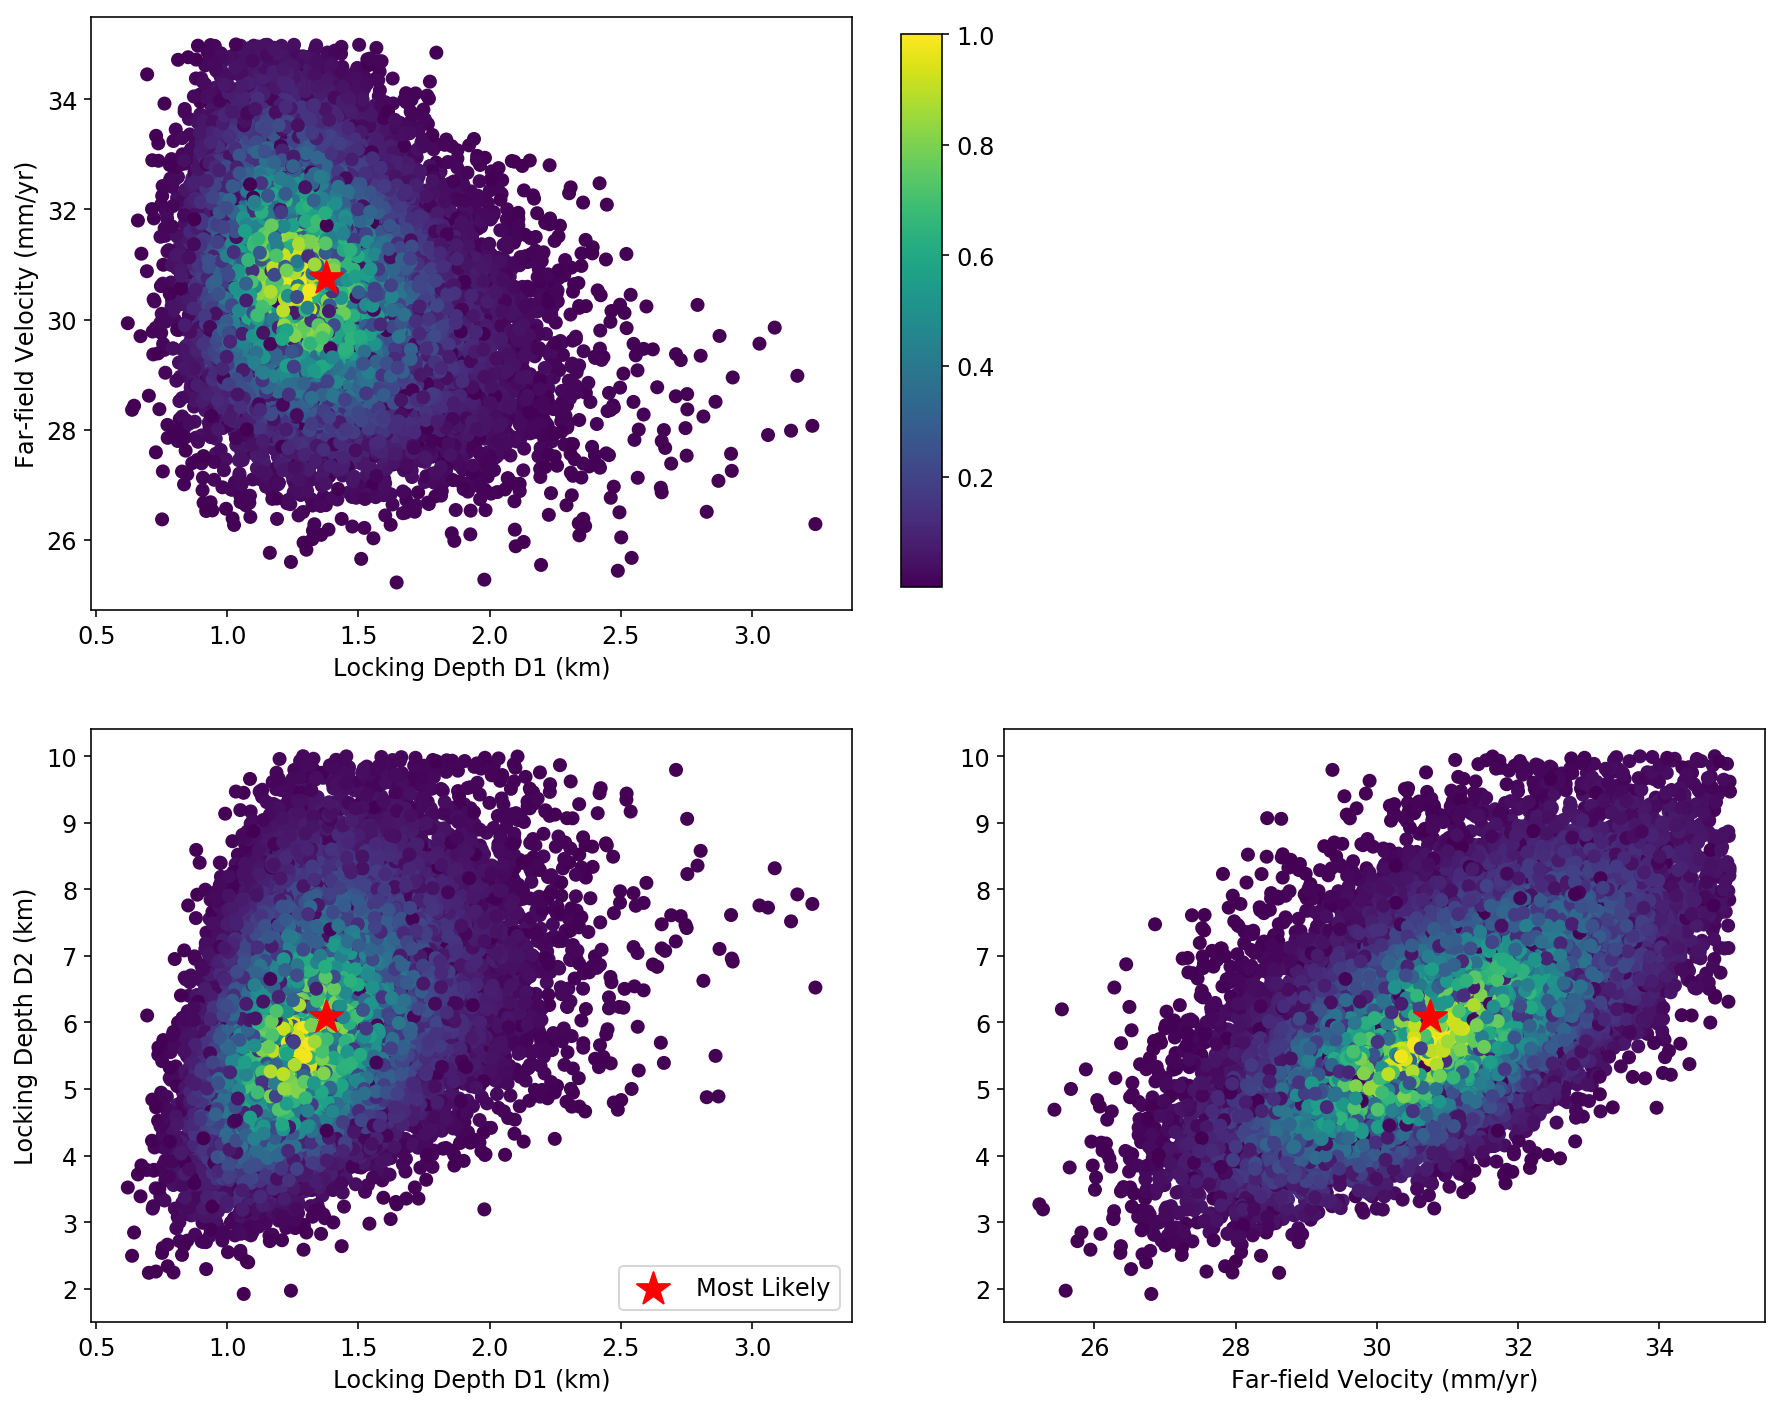

In [78]:
# Locking Depth and far field velocity
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 12})
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(224)
ax3 = fig.add_subplot(223)

col = ax1.scatter(D1_post, np.abs(vo_post), c=np.abs(misfit_post))
#ax1.tricontourf(D1_post, np.abs(vo_post), np.abs(misfit_post), 14, cmap='viridis')
ax1.scatter(D1_ml, np.abs(vo_ml), s=300, marker="*", color="Red", label="Most Likely")
ax1.set_xlabel("Locking Depth D1 (km)")
ax1.set_ylabel("Far-field Velocity (mm/yr)")

ax2.scatter(np.abs(vo_post), D2_post, c=np.abs(misfit_post))
#ax2.tricontourf(np.abs(vo_post), D2_post, np.abs(misfit_post), 14, cmap='viridis')
ax2.scatter(np.abs(vo_ml), D2_ml, s=300, marker="*", color="Red", label="Most Likely")
ax2.set_xlabel("Far-field Velocity (mm/yr)")

ax3.scatter(D1_post, D2_post, c=np.abs(misfit_post))
#c = ax3.tricontourf(D1_post, D2_post, np.abs(misfit_post), 14, cmap='viridis')
ax3.scatter(D1_ml, D2_ml, s=300, marker="*", color="Red", label="Most Likely")
ax3.set_xlabel("Locking Depth D1 (km)")
ax3.set_ylabel("Locking Depth D2 (km)")

plt.legend()
cbar_ax = fig.add_axes([0.50, 0.55, 0.019, 0.32])    # [x-coord, y-coord, thickness, height] of the colorbar
fig.colorbar(col, cax=cbar_ax)

plt.savefig("../plots/modelIIuncertainties.pdf", dpi=300)
plt.show()

In [38]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sys import argv

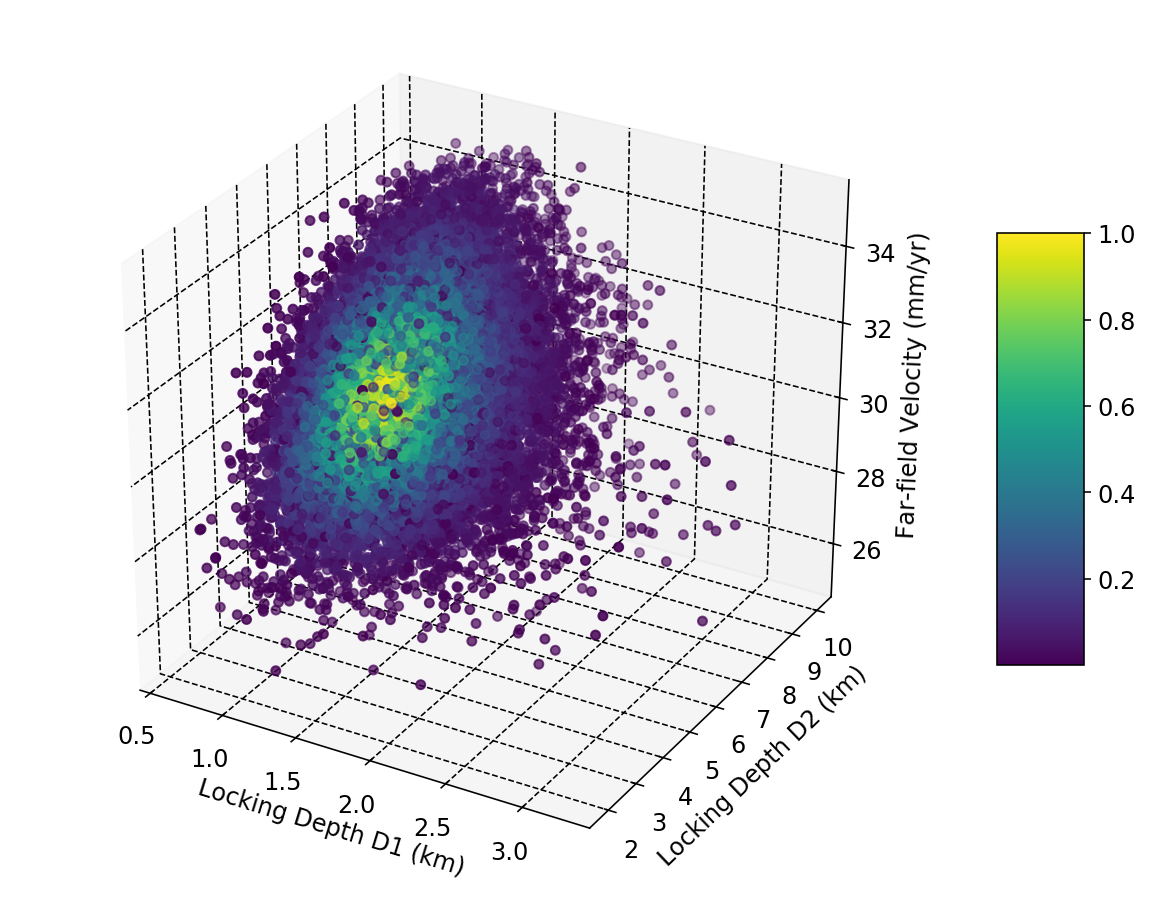

In [53]:
fig = plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 12})
ax = Axes3D(fig)

#ax1.scatter(D1_post, np.abs(vo_post), s=10)
#ax.tricontour(D_post, np.abs(vo_post), np.abs(misfit_post), 14, linewidths=0.5, colors='k')
#c = ax1.tricontourf(D1_post, np.abs(vo_post), np.abs(misfit_post), 14, cmap='viridis')
#ax1.scatter(D1_ml, np.abs(vo_ml), s=300, marker="*", color="Red", label="Most Likely")

surf = ax.scatter(D1_post, D2_post, vo_post, c=np.abs(misfit_post), cmap="viridis")
#ax.scatter(D1_ml, D2_ml, vo_ml,  s=300, marker="*", color="Red", label="Most Likely")
ax.set_xlabel("Locking Depth D1 (km)")
ax.set_ylabel("Locking Depth D2 (km)")
ax.set_zlabel("Far-field Velocity (mm/yr)")

fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.legend()
#plt.colorbar(c)
plt.savefig("../plots/modelIIuncertainties_3d.pdf", dpi=300)
plt.show()

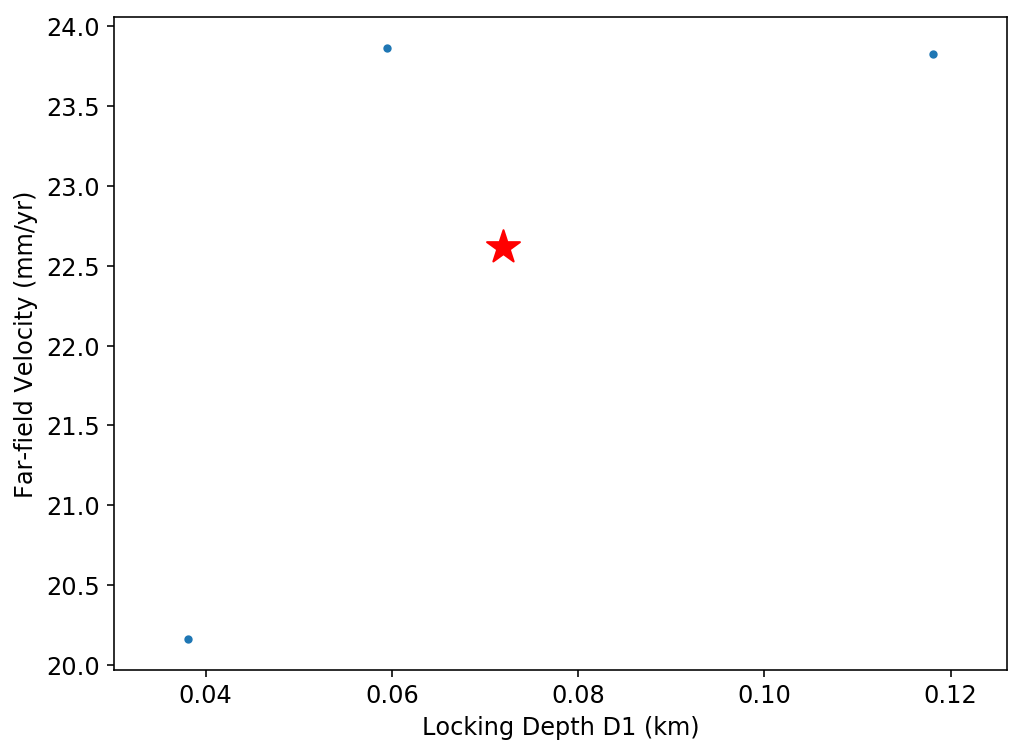

In [12]:
# Locking Depth and far field velocity
fig = plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 12})
ax1 = fig.add_subplot(111)

ax1.scatter(D1_post, np.abs(vo_post), s=10)
#ax.tricontour(D_post, np.abs(vo_post), np.abs(misfit_post), 14, linewidths=0.5, colors='k')
#c = ax1.tricontourf(D1_post, np.abs(vo_post), np.abs(misfit_post), 14, cmap='viridis')
ax1.scatter(D1_ml, np.abs(vo_ml), s=300, marker="*", color="Red", label="Most Likely")
ax1.set_xlabel("Locking Depth D1 (km)")
ax1.set_ylabel("Far-field Velocity (mm/yr)")

#plt.colorbar(c)
plt.savefig("../plots/modelIuncertainties.pdf", dpi=300)
plt.show()

In [ ]:
#plt.plot(l2_misfit/np.amax(l2_misfit), ".")

In [59]:
np.rad2deg(α)

array([-57.1434159 , -57.1434159 , -57.1434159 , -57.1434159 ,
       -57.1434159 , -53.22303503, -53.22303503, -53.22303503,
       -53.22303503, -53.94386368, -53.94386368, -42.80318333,
       -42.80318333, -53.50511206, -53.50511206, -53.50511206,
       -53.50511206, -53.50511206, -53.50511206, -53.35075253,
       -53.35075253, -53.35075253, -53.35075253, -52.079932  ,
       -52.079932  , -52.079932  , -52.079932  , -52.079932  ,
       -50.11210498, -50.11210498, -50.11210498, -50.11210498,
       -50.11210498, -50.11210498, -54.93027395, -54.93027395,
       -54.93027395, -54.93027395, -54.93027395, -57.22760122,
       -57.22760122, -57.22760122, -57.22760122, -57.22760122,
       -51.77919322, -51.77919322, -51.06676236, -51.06676236,
       -51.06676236, -51.06676236, -51.06676236, -51.74105421,
       -51.74105421, -51.85423196, -51.85423196, -50.28187452,
       -50.28187452, -50.59640233, -50.59640233, -50.59640233,
       -50.69277408, -50.69277408, -53.08311936, -53.08